In [1]:
from conditional_inference.quantile_unbiased import RQU

import numpy as np
import pandas as pd
import seaborn as sns
from dask import delayed
from dask.distributed import Client
from scipy.stats import norm

import random
import time
from itertools import product
from math import ceil

# number of simulations per configuration
n_simulations = 500
# number of batches to run
n_batches = 1
batch_size = ceil(n_simulations / n_batches)
# a configuration is a combination of parameters
param_space = dict(
    n_policies=(2, 10, 50),
    best_effect=np.arange(9)
)
client = Client(n_workers=4)

In [2]:
def compute_conventional_estimate(x, sigma_x):
    idx = x.argmax()
    point, std = x[idx], np.sqrt(sigma_x[idx, idx])
    return np.array([point, point - 1.96 * std, point + 1.96 * std])

def compute_conditional_estimate(x, sigma_x):
    dist = RQU(x, sigma_x).get_distribution()
    return dist.ppf([.5, .025, .975])

def compute_hybrid_estimate(x, sigma_x):
    beta = .005
    alpha = (.05 - beta) / (1 - beta)
    dist = RQU(x, sigma_x).get_distribution(beta=beta)
    return dist.ppf([.5, alpha / 2, 1 - alpha / 2])

def compute_projection_estimate(x, sigma_x):
    idx = x.argmax()
    point = x[idx]
    c_alpha = RQU(x, sigma_x).compute_projection_quantile()
    projection = c_alpha * np.sqrt(sigma_x[idx, idx])
    return np.array([point, point - projection, point + projection])

estimators = [
    ("Conventional", compute_conventional_estimate),
    ("Conditional", compute_conditional_estimate),
    ("Hybrid", compute_hybrid_estimate),
    ("Projection", compute_projection_estimate)
]

In [3]:
%%time

def run_simulation(idx, n_policies, best_effect):
    def get_estimates(estimator, x, sigma_x):
        name, estimator = estimator
        point, ppf_025, ppf_975 = estimator(x, sigma_x)
        return dict(
            Estimator=name,
            Point=point,
            PPF_025=ppf_025,
            PPF_975=ppf_975,
        )

    x = np.insert(
        norm().rvs(size=n_policies-1), 0, norm(loc=best_effect).rvs()
    )
    sigma_x = np.identity(n_policies)
    df = pd.DataFrame([
        get_estimates(estimator, x, sigma_x) for estimator in estimators
    ])
    df["Simulation"] = idx
    df["NPolicies"] = n_policies
    df["RecommendedEffect"] = best_effect if x.argmax() == 0 else 0
    df["BestEffect"] = best_effect
    return df

def run_simulations(batch_no, params):
    simulations = range(
        batch_no*batch_size, 
        min(n_simulations, (batch_no+1)*batch_size)
    )
    return pd.concat([run_simulation(i, **params) for i in simulations])

param_grid = list(product(*param_space.values()))
param_grid = [
    {key: val for key, val in zip(param_space.keys(), config)} 
    for config in param_grid
]
results = [
    delayed(run_simulations)(batch_no, params)
    for batch_no, params in product(range(n_batches), param_grid)
]
result_df = delayed(pd.concat)(results).compute()
result_df.head()

Wall time: 18min 7s


Estimator     Point    PPF_025   PPF_975  Simulation  NPolicies  \
0  Conventional -0.696416  -2.656416  1.263584           0          2   
1   Conditional -8.529406 -17.873759  0.220598           0          2   
2        Hybrid -3.635120  -3.829638  0.299142           0          2   
3    Projection -0.696416  -2.923732  1.530900           0          2   
0  Conventional  1.404849  -0.555151  3.364849           1          2   

   RecommendedEffect  BestEffect  
0                  0           0  
1                  0           0  
2                  0           0  
3                  0           0  
0                  0           0

In [4]:
result_df["InRange"] = (
    (result_df.PPF_025 < result_df.RecommendedEffect)
    & (result_df.RecommendedEffect < result_df.PPF_975)
)
result_df["Error"] = abs(result_df.Point - result_df.RecommendedEffect)
result_df["ProbabilityBias"] = (
    (result_df.Point > result_df.RecommendedEffect) - .5
)
result_df["CILength"] = result_df.PPF_975 - result_df.PPF_025

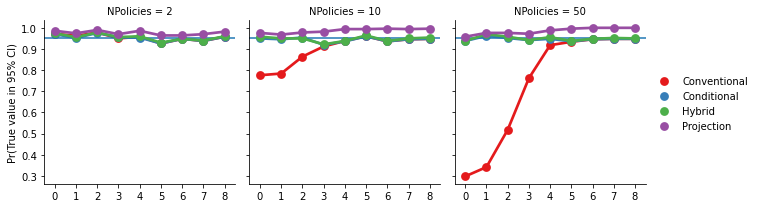

In [5]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="InRange", 
    hue="Estimator", 
    ci=None,
    palette="Set1"
)
[ax.axhline(.95) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("Pr(True value in 95% CI)")

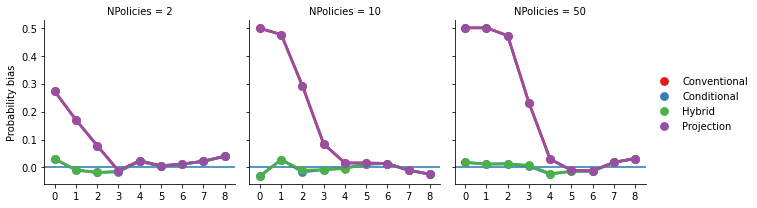

In [6]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="ProbabilityBias", 
    hue="Estimator", 
    ci=None,
    palette="Set1"
)
[ax.axhline(0) for ax in g.axes[0]]
g.add_legend()
g.set_ylabels("Probability bias")

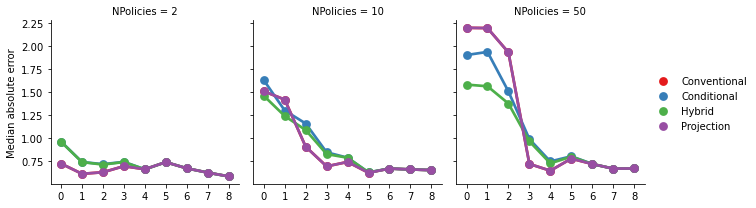

In [7]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="Error", 
    hue="Estimator", 
    estimator=lambda x: np.quantile(x, .5), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("Median absolute error")

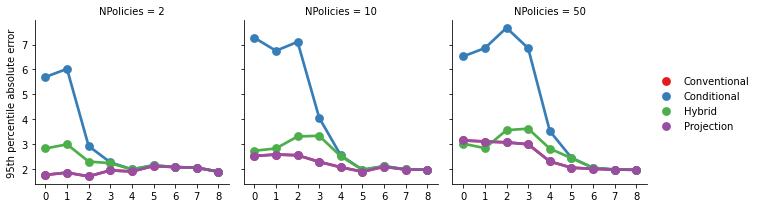

In [8]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="Error", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .95), 
    ci=None,
    palette="Set1"
)
g.add_legend()
g.set_ylabels("95th percentile absolute error")

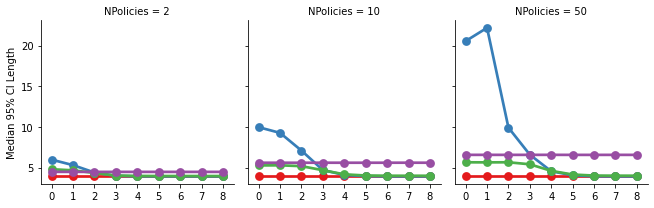

In [9]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="CILength", 
    hue="Estimator", 
    estimator=lambda x: np.quantile(x, .5), 
    ci=None,
    palette="Set1"
)
g.set_ylabels("Median 95% CI Length")

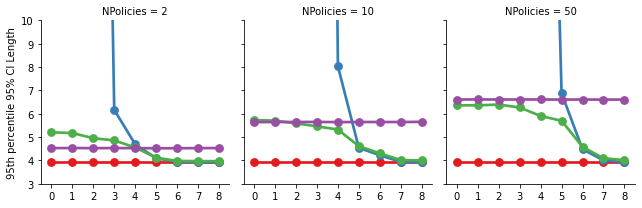

In [12]:
g = sns.FacetGrid(result_df, col="NPolicies")
g.map_dataframe(
    sns.pointplot, 
    x="BestEffect", 
    y="CILength", 
    hue="Estimator",
    estimator=lambda x: np.quantile(x, .95), 
    ci=None,
    palette="Set1"
)
g.set(ylim=(3, 10))
g.set_ylabels("95th percentile 95% CI Length")

In [11]:
client.close()